# Model Evaluation

This notebook has example code to be able to train a custom model and visualise performance using Vertex AI Pipelines. This is a regression model predicting the total fare of taxi trips from the BigQuery Chicago Taxi Trips dataset. The datasets were created using the query

SELECT
  CAST(EXTRACT(DAYOFWEEK
    FROM
      trip_start_timestamp) AS FLOAT64) AS dayofweek,
  CAST(EXTRACT(HOUR
    FROM
      trip_start_timestamp) AS FLOAT64) AS hourofday,
  ST_DISTANCE( ST_GEOGPOINT(pickup_longitude, pickup_latitude), ST_GEOGPOINT(dropoff_longitude, dropoff_latitude)) AS trip_distance,
  trip_miles,
  CAST(
    CASE
      WHEN trip_seconds IS NULL THEN 1
      WHEN trip_seconds <= 0 THEN 1
    ELSE
    trip_seconds
  END
    AS FLOAT64) AS trip_seconds,
  (fare + tips + tolls + extras) AS total_fare,
FROM
  `<CHICAGO_TAXI_DATA>`
WHERE
  trip_miles > 0
  AND fare > 0
  AND fare < 1500
  AND fare IS NOT NULL
  AND tips IS NOT NULL
  AND tolls IS NOT NULL
  AND extras IS NOT NULL 
  AND trip_start_timestamp IS NOT NULL
  AND pickup_longitude IS NOT NULL
  AND pickup_latitude IS NOT NULL
  AND dropoff_longitude IS NOT NULL
  AND dropoff_latitude IS NOT NULL
  AND payment_type IS NOT NULL
  AND company IS NOT NULL
  AND trip_start_timestamp BETWEEN "2021-01-01"
  AND "2021-12-31"
LIMIT
  10000
  
The pipeline assumes that the training, validation, and test datasets have already been created in BigQuery and exported to GCS.

In [ ]:
# Install required libraries to submit pipeline
# !pip install kfp==1.8.17 google-cloud-pipeline-components==1.0.37

In [ ]:
import json
import kfp
from google.cloud import aiplatform
from kfp.v2 import dsl
from kfp.v2.dsl import Artifact, Input, Output, Dataset, Model, component
from kfp.v2.components import importer_node

from google_cloud_pipeline_components.experimental.custom_job.utils import (
    create_custom_training_job_op_from_component
)

from google_cloud_pipeline_components.aiplatform import ModelBatchPredictOp, ModelUploadOp
from google_cloud_pipeline_components.experimental.evaluation import (
        ModelEvaluationFeatureAttributionOp, ModelEvaluationRegressionOp,
        ModelImportEvaluationOp)

In [ ]:
project_id = "<PROJECT_ID>"
dataset_id = "<DATASET_ID>"
bq_training_data = f"bq://{project_id}.{dataset_id}.training_data"
bq_validation_data = f"bq://{project_id}.{dataset_id}.validation_data"
bq_test_data = f"bq://{project_id}.{dataset_id}.test_data"
bq_test_data_no_label = f"bq://{project_id}.{dataset_id}.test_data_no_label"
gcs_training_data = "gs://<GCS_BUCKET>/training_data.csv"
gcs_validation_data = "gs://<GCS_BUCKET>/validation_data.csv"
gcs_test_data = "gs://<GCS_BUCKET>/test_data.csv"
label_name = "total_fare"
pipeline_root = "gs://<GCS_ROOT_BUCKET>"
location = "europe-west1"
service_account = "<SERVICE_ACCOUNT>"
subnetwork = "<SUBNETWORK>"

In [ ]:
@component(
    base_image="python:3.7",
    packages_to_install=["xgboost==1.4.2", "scikit-learn==0.24.2", "pandas==1.3.2", "gcsfs==0.7.1", "pyarrow==8.0.0"],
)
def train_xgboost_model(
    training_data: str,
    validation_data: str,
    label_name: str,
    model_params: dict,
    model: Output[Model],
    metrics_artifact: Output[Artifact],
) -> None:
    """Train an XGBoost model.
    Args:
        training_data (str): GCS location of training data.
        validation_data (str): GCS location of validation data.
        label_name (str): CSV column name containing the label data.
        model_params (dict): Dictionary of following training parameters
            num_iterations: int - Number of boosting iterations.
            booster_params: int/str/float - Parameters for the booster.
                See https://xgboost.readthedocs.io/en/latest/parameter.html
            early_stopping_rounds: int - Early stopping rounds (optional).
        model (Output[Model]): Output model as a kfp Model object.
            Attribute .path is the GCS location for the trained model
            in XGBoost bst format
        metrics_artifact (Output[Artifact]): Output metrics of all iterations for
            the trained model in JSON format.
    Returns:
        None
    """
    import json
    import os
    import logging
    import pandas
    from xgboost import XGBRegressor

    # numeric features in data for reference
    NUM_COLS = ["dayofweek", "hourofday", "trip_distance", "trip_miles", "trip_seconds"]

    logging.getLogger().setLevel(logging.INFO)

    logging.info("Read train & validation data into pandas dataframes")
    train_df = pandas.read_csv(training_data)
    valid_df = pandas.read_csv(validation_data)

    logging.info("Split train/validation data into features & labels")
    X_train, y_train = (
        train_df.drop(columns=[label_name]),
        train_df[label_name],
    )
    X_valid, y_valid = (
        valid_df.drop(columns=[label_name]),
        valid_df[label_name],
    )

    logging.info("Build XGBoost model")
    xgb_model = XGBRegressor(**model_params)
    xgb_model.fit(
        X_train, y_train, eval_set=[(X_valid, y_valid)]
    )

    logging.info("Save evaluation results to a dictionary")
    evals_result = xgb_model.evals_result()

    # ensure to change GCS to local mount path
    os.makedirs(model.path, exist_ok=True)

    logging.info(f"Save model to: {model.path}")
    xgb_model.save_model(model.path + "/model.bst")

    logging.info(f"Save metrics to: {metrics_artifact.path}")
    with open(metrics_artifact.path, "w") as fp:
        json.dump(evals_result, fp)

In [ ]:
# We need a custom component to add the model to an UnManagedContainerModel artifact, 
# so that it can be uploaded as a Google.VertexModel later. See here for reference:
# https://cloud.google.com/vertex-ai/docs/pipelines/use-components#use_python_function-based_components
@component(base_image='python:3.7',packages_to_install=['google-cloud-aiplatform'])
def return_unmanaged_model(
    trained_model: Input[Model],
    model: Output[Artifact]
) -> None:
    """
    Fetch a trained model to be uploaded and attach serving image.
    Args:
        trained_model (Input[Model]): Model to be uploaded.
        model (Output[Artifact]): Artifact that can be uploaded as a Google.VertexModel object.
            Currently KFP doesn't support outputting artifacts in Google namespace,
            so we need to manipulate the base type Artifact instead.
    Returns:
        None.
    """
    model.metadata['containerSpec'] = {
      'imageUri':
          "europe-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest"
          }
    model.uri = trained_model.uri.rsplit("/", 1)[0] + "/model"

In [ ]:
@kfp.dsl.pipeline(name="custom-model-evaluation", pipeline_root=pipeline_root)
def pipeline(
):    
    # train xgboost model
    model_params = dict(
        n_estimators=200,
        early_stopping_rounds=10,
        objective="reg:squarederror",
        booster="gbtree",
        learning_rate=0.3,
        min_split_loss=0,
        max_depth=6,
    )

    train_model = (
        custom_train_job(
            training_data=gcs_training_data,
            validation_data=gcs_validation_data,
            label_name=label_name,
            model_params=json.dumps(model_params),
            # Training wrapper specific parameters
            project=project_id,
            location=location,
        )
        .set_display_name("Vertex Training for XGB model")
    )

    xgboost_model = train_model.outputs["model"]
   
    unmanaged_model_op = return_unmanaged_model(trained_model=xgboost_model)
    
    model_upload_task = ModelUploadOp(
        project = project_id,
        location = location,
        display_name = "xgboost_chicago_regressor",
        unmanaged_container_model=unmanaged_model_op.outputs['model'])
    
    # Run Batch Explanations
    batch_explain_task = ModelBatchPredictOp(
        project=project_id,
        location=location,
        model=model_upload_task.outputs["model"],
        job_display_name="xgboost-regressor-batch-predict-evaluation",
        bigquery_source_input_uri=bq_test_data_no_label,
        instances_format="bigquery",
        predictions_format="bigquery",
        bigquery_destination_output_uri=f"bq://{project_id}.{dataset_id}",
        machine_type="n1-standard-4",
        # Set the explanation parameters
        generate_explanation=True,
    )
    
    # Run evaluation based on prediction type and feature attribution component.
    # After, import the model evaluations to the Vertex AI Model resource.
    eval_task = ModelEvaluationRegressionOp(
        project=project_id,
        location=location,
        root_dir=pipeline_root,
        predictions_bigquery_source=batch_explain_task.outputs["bigquery_output_table"],
        ground_truth_format="bigquery",
        ground_truth_bigquery_source=bq_test_data,
        predictions_format="bigquery",
        prediction_score_column="prediction",
        target_field_name=label_name,
        dataflow_service_account=service_account,
        dataflow_subnetwork=subnetwork,
    )
    
    # Get Feature Attributions
    feature_attribution_task = ModelEvaluationFeatureAttributionOp(
        project=project_id,
        location=location,
        root_dir=pipeline_root,
        predictions_format="bigquery",
        predictions_bigquery_source=batch_explain_task.outputs["bigquery_output_table"],
        dataflow_service_account=service_account,
        dataflow_subnetwork=subnetwork,
    )

    # Import evaluations into UI
    ModelImportEvaluationOp(
        display_name="XGBoost Metrics",
        regression_metrics=eval_task.outputs["evaluation_metrics"],
        feature_attributions=feature_attribution_task.outputs["feature_attributions"],
        model=model_upload_task.outputs["model"],
    )


In [ ]:
from kfp.v2 import compiler

custom_train_job = create_custom_training_job_op_from_component(
        component_spec=train_xgboost_model,
        replica_count=1,
        machine_type="n1-standard-4",
    )

compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="custom_model_evaluation.json",
)

In [ ]:
# Configure the pipeline
job = aiplatform.PipelineJob(
    display_name="custom-model-evaluation",
    template_path="custom_model_evaluation.json",
    location=location,
    pipeline_root=pipeline_root,
    parameter_values={
    },
    enable_caching=False,
)

In [ ]:
# Run the job
job.submit(
    service_account=service_account)

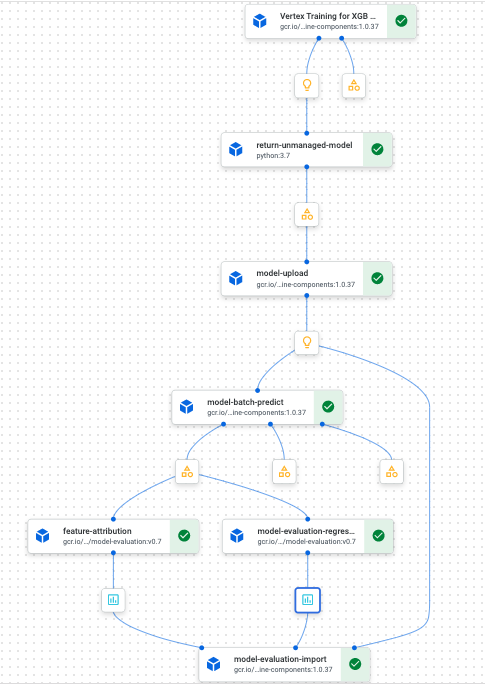

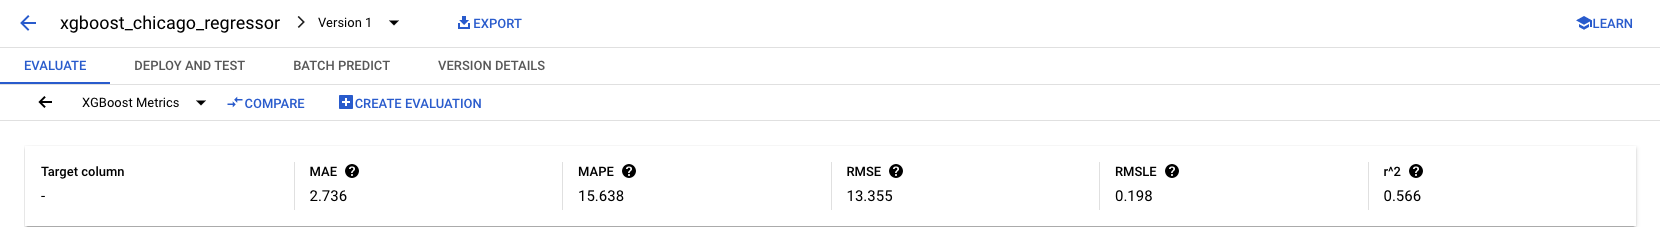